# The core objective is to predict electricity demand for every 10-minute block of the day(144 blocks total) for APU, a major power provider.


##  **Dataset:** Utility consumption data (10-min intervals) + weather + holidays
## **Tools Used:** Python, Pandas, Prophet, Matplotlib, Seaborn

## Exploratory Data Analysis (EDA) & Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


### Load Data

In [2]:
df = pd.read_csv("C:/Users/ASUS/Downloads/Assignment-1, Intelligent-Power-Demand-Forecasting/Data/Utility_consumption.csv")


#### The provided data is in mixed formet so we have used Formet - mixed below

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed',errors ='coerce')

In [4]:
df

,Datetime,Temperature,Humidity,WindSpeed,F1_132KV_PowerConsumption,F2_132KV_PowerConsumption,F3_132KV_PowerConsumption
0,2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,31160.45627,26857.31820,14780.31212
52412,2017-12-30 23:20:00,6.947,72.6,0.082,30430.41825,26124.57809,14428.81152
52413,2017-12-30 23:30:00,6.900,72.8,0.086,29590.87452,25277.69254,13806.48259
52414,2017-12-30 23:40:00,6.758,73.0,0.080,28958.17490,24692.23688,13512.60504


## Goal: Understand structure, missing data, and basic stats of columns.

### Inspect Data

In [5]:
#checking missing values
df.Datetime.isna().sum()

0

In [6]:
print(df.head())


             Datetime  Temperature  Humidity  WindSpeed  \
0 2017-01-01 00:00:00        6.559      73.8      0.083   
1 2017-01-01 00:10:00        6.414      74.5      0.083   
2 2017-01-01 00:20:00        6.313      74.5      0.080   
3 2017-01-01 00:30:00        6.121      75.0      0.083   
4 2017-01-01 00:40:00        5.921      75.7      0.081   

   F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                34055.69620                16128.87538   
1                29814.68354                19375.07599   
2                29128.10127                19006.68693   
3                28228.86076                18361.09422   
4                27335.69620                17872.34043   

   F3_132KV_PowerConsumption  
0                20240.96386  
1                20131.08434  
2                19668.43373  
3                18899.27711  
4                18442.40964  


###  Checking Null values

In [7]:
print(df.isnull().sum())  # Check missing values

Datetime                     0
Temperature                  0
Humidity                     0
WindSpeed                    0
F1_132KV_PowerConsumption    0
F2_132KV_PowerConsumption    0
F3_132KV_PowerConsumption    0
dtype: int64


### Checking Duplicat values 

In [8]:
# Check if there are any duplicate rows, True → row is a duplicate, False → row is unique
duplicates = df.duplicated()
print(duplicates.value_counts())

False    52416
Name: count, dtype: int64


In [9]:
#Show all duplicate rows

duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [Datetime, Temperature, Humidity, WindSpeed, F1_132KV_PowerConsumption, F2_132KV_PowerConsumption, F3_132KV_PowerConsumption]
Index: []


## Visual Exploration (EDA)

### Goal: Identify patterns, and outliers visually.

### Finding Which Weather Parameter Affects Consumption Most

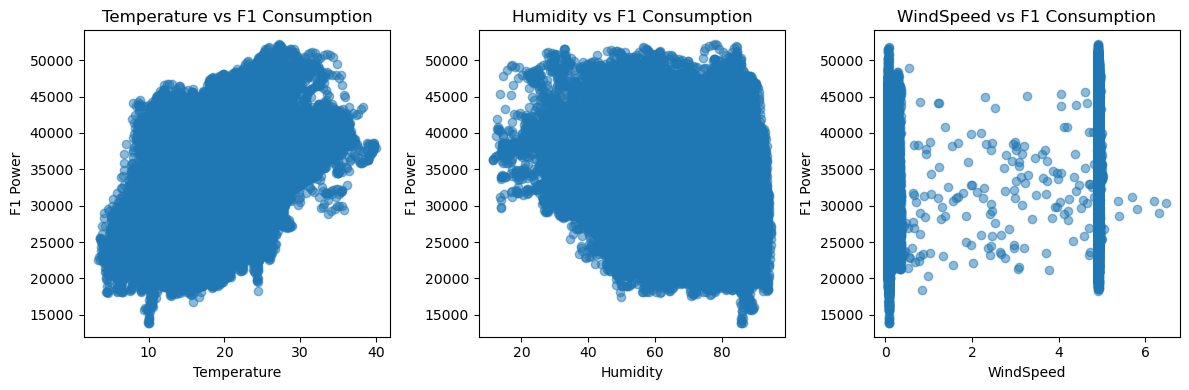

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(df['Temperature'], df['F1_132KV_PowerConsumption'], alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('F1 Power')
plt.title('Temperature vs F1 Consumption')

plt.subplot(1,3,2)
plt.scatter(df['Humidity'], df['F1_132KV_PowerConsumption'], alpha=0.5)
plt.xlabel('Humidity')
plt.ylabel('F1 Power')
plt.title('Humidity vs F1 Consumption')

plt.subplot(1,3,3)
plt.scatter(df['WindSpeed'], df['F1_132KV_PowerConsumption'], alpha=0.5)
plt.xlabel('WindSpeed')
plt.ylabel('F1 Power')
plt.title('WindSpeed vs F1 Consumption')

plt.tight_layout()
plt.show()


## Which Months have higher average power consumption?

In [11]:
# If there's no Datetime column, create one assuming 10-min intervals starting 01-01-2017 00:00

N = len(df)
df['Datetime'] = pd.date_range(start='2017-01-01 00:00', periods=N, freq='10T')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28744\460611869.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['Datetime'] = pd.date_range(start='2017-01-01 00:00', periods=N, freq='10T')


In [12]:
# datetime is index now not column
df.set_index('Datetime', inplace=True)

In [13]:
print(df.columns) # 5th vale box me jaa df ka column dekh

Index(['Temperature', 'Humidity', 'WindSpeed', 'F1_132KV_PowerConsumption',
       'F2_132KV_PowerConsumption', 'F3_132KV_PowerConsumption'],
      dtype='object')


In [14]:
# Aggregate power consumption and weather data by month (mean)
df_monthly = df.resample('M').mean()  # 'M' = month-end frequency

# Check result
print(df_monthly.head())

            Temperature   Humidity  WindSpeed  F1_132KV_PowerConsumption  \
Datetime                                                                   
2017-01-31    12.743092  68.294122   0.707927               31032.493535   
2017-02-28    12.644443  66.551322   1.096494               30985.753632   
2017-03-31    14.579907  71.100029   1.006189               31155.165408   
2017-04-30    16.444463  75.242521   0.224269               31169.768210   
2017-05-31    20.293564  68.712440   2.298271               32396.009166   

            F2_132KV_PowerConsumption  F3_132KV_PowerConsumption  
Datetime                                                          
2017-01-31               19394.444717               17746.095349  
2017-02-28               18787.793096               17335.002154  
2017-03-31               18457.937484               16947.686004  
2017-04-30               17633.966395               18593.167677  
2017-05-31               19977.287859               17621.100953 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28744\2433276083.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()  # 'M' = month-end frequency


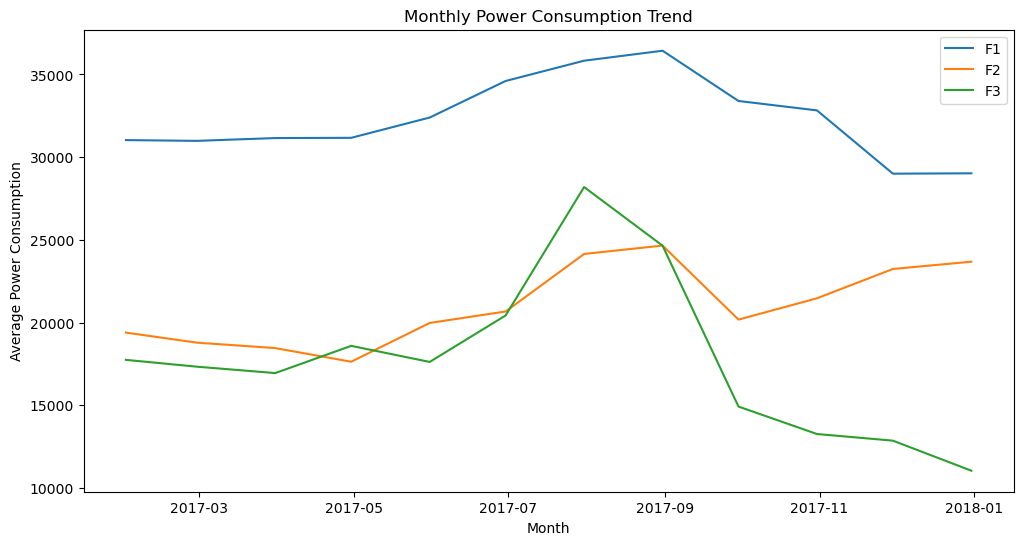

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['F1_132KV_PowerConsumption'], label='F1')
plt.plot(df_monthly.index, df_monthly['F2_132KV_PowerConsumption'], label='F2')
plt.plot(df_monthly.index, df_monthly['F3_132KV_PowerConsumption'], label='F3')
plt.xlabel('Month')
plt.ylabel('Average Power Consumption')
plt.title('Monthly Power Consumption Trend')
plt.legend()
plt.show()

### Outliers Detection in utility data

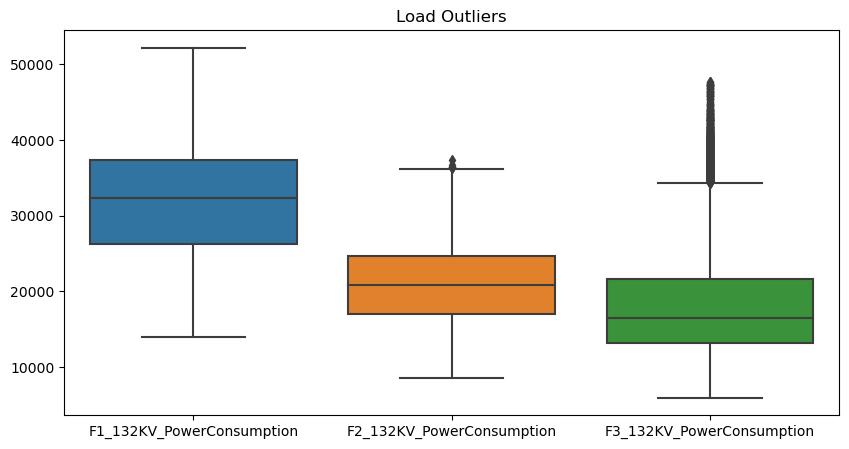

In [16]:
# Boxplot to Detect Outliers

plt.figure(figsize=(10,5))
sns.boxplot(data=df[['F1_132KV_PowerConsumption','F2_132KV_PowerConsumption','F3_132KV_PowerConsumption']])
plt.title('Load Outliers')
plt.show()

## Load Weather Data

In [17]:
import requests
import pandas as pd
# Coordinates for Dhanbad
lat, lon = 23.7957, 86.4304
# Open-Meteo Historical Weather API
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": "2017-01-01",
    "end_date": "2017-12-31",
    "hourly": ["temperature_2m", "relative_humidity_2m", "dewpoint_2m", 
               "surface_pressure", "precipitation", "windspeed_10m"]
}
response = requests.get(url, params=params)
data = response.json()

# Convert to DataFrame
df_weather = pd.DataFrame(data["hourly"])
df_weather["time"] = pd.to_datetime(df_weather["time"])

print(df_weather)

                    time  temperature_2m  relative_humidity_2m  dewpoint_2m  \
0    2017-01-01 00:00:00            14.4                    93         13.3   
1    2017-01-01 01:00:00            13.8                    96         13.2   
2    2017-01-01 02:00:00            16.1                    89         14.2   
3    2017-01-01 03:00:00            18.9                    78         14.9   
4    2017-01-01 04:00:00            21.2                    69         15.3   
...                  ...             ...                   ...          ...   
8755 2017-12-31 19:00:00            14.1                    84         11.5   
8756 2017-12-31 20:00:00            13.6                    85         11.2   
8757 2017-12-31 21:00:00            13.2                    87         11.0   
8758 2017-12-31 22:00:00            12.7                    89         10.9   
8759 2017-12-31 23:00:00            12.3                    91         10.8   

      surface_pressure  precipitation  windspeed_10

### Analysing the weather data 

In [18]:
print(df_weather.columns)

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'dewpoint_2m',
       'surface_pressure', 'precipitation', 'windspeed_10m'],
      dtype='object')


In [19]:
print(df_weather.head())

                 time  temperature_2m  relative_humidity_2m  dewpoint_2m  \
0 2017-01-01 00:00:00            14.4                    93         13.3   
1 2017-01-01 01:00:00            13.8                    96         13.2   
2 2017-01-01 02:00:00            16.1                    89         14.2   
3 2017-01-01 03:00:00            18.9                    78         14.9   
4 2017-01-01 04:00:00            21.2                    69         15.3   

   surface_pressure  precipitation  windspeed_10m  
0             987.1            0.0            5.6  
1             987.8            0.0            4.4  
2             988.8            0.0            4.3  
3             989.8            0.0            2.2  
4             990.4            0.0            2.8  


### Inspect data 

In [20]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  8760 non-null   datetime64[ns]
 1   temperature_2m        8760 non-null   float64       
 2   relative_humidity_2m  8760 non-null   int64         
 3   dewpoint_2m           8760 non-null   float64       
 4   surface_pressure      8760 non-null   float64       
 5   precipitation         8760 non-null   float64       
 6   windspeed_10m         8760 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 479.2 KB
None


In [21]:
print(df_weather.describe())


                      time  temperature_2m  relative_humidity_2m  dewpoint_2m  \
count                 8760     8760.000000           8760.000000  8760.000000   
mean   2017-07-02 11:30:00       25.235377             69.480137    18.155023   
min    2017-01-01 00:00:00        7.500000              8.000000    -1.500000   
25%    2017-04-02 05:45:00       21.800000             54.000000    12.000000   
50%    2017-07-02 11:30:00       25.900000             75.000000    20.500000   
75%    2017-10-01 17:15:00       28.700000             88.000000    24.300000   
max    2017-12-31 23:00:00       41.200000            100.000000    27.400000   
std                    NaN        5.867821             21.957739     6.797461   

       surface_pressure  precipitation  windspeed_10m  
count       8760.000000    8760.000000    8760.000000  
mean         979.985171       0.159372       8.251838  
min          966.900000       0.000000       0.000000  
25%          975.300000       0.000000       5

### Checking Null Values in weather data

In [22]:
print(df_weather.isnull().sum())

time                    0
temperature_2m          0
relative_humidity_2m    0
dewpoint_2m             0
surface_pressure        0
precipitation           0
windspeed_10m           0
dtype: int64


### Checking Duplicate values in weather data

In [23]:
#Show all duplicate rows

duplicate_rowsWeather = df_weather[df_weather.duplicated()]
print(duplicate_rowsWeather)

Empty DataFrame
Columns: [time, temperature_2m, relative_humidity_2m, dewpoint_2m, surface_pressure, precipitation, windspeed_10m]
Index: []


#  Load Holiday data 

In [24]:
import pandas as pd
import holidays

# Generate all dates for 2017
dates = pd.date_range(start="2017-01-01", end="2017-12-31", freq="D")

# Get Indian holidays
#ind_holidays = holidays.India(years=[2017])
ind_holidays = holidays.India(years=[2017], prov="JH")
# Build DataFrame
calendar_df = pd.DataFrame({
    "date": dates,
})

# Mark holidays
calendar_df["is_holiday"] = calendar_df["date"].isin(ind_holidays).astype(int)
calendar_df["holiday_name"] = calendar_df["date"].map(ind_holidays).fillna("Not a Holiday")

# Mark weekends
calendar_df["is_weekend"] = (calendar_df["date"].dt.dayofweek >= 5).astype(int)

print(calendar_df.head(30))

         date  is_holiday   holiday_name  is_weekend
0  2017-01-01           0  Not a Holiday           1
1  2017-01-02           0  Not a Holiday           0
2  2017-01-03           0  Not a Holiday           0
3  2017-01-04           0  Not a Holiday           0
4  2017-01-05           0  Not a Holiday           0
5  2017-01-06           0  Not a Holiday           0
6  2017-01-07           0  Not a Holiday           1
7  2017-01-08           0  Not a Holiday           1
8  2017-01-09           0  Not a Holiday           0
9  2017-01-10           0  Not a Holiday           0
10 2017-01-11           0  Not a Holiday           0
11 2017-01-12           0  Not a Holiday           0
12 2017-01-13           0  Not a Holiday           0
13 2017-01-14           0  Not a Holiday           1
14 2017-01-15           0  Not a Holiday           1
15 2017-01-16           0  Not a Holiday           0
16 2017-01-17           0  Not a Holiday           0
17 2017-01-18           0  Not a Holiday      

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28744\3679648383.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  calendar_df["is_holiday"] = calendar_df["date"].isin(ind_holidays).astype(int)


In [25]:
print(calendar_df)

          date  is_holiday   holiday_name  is_weekend
0   2017-01-01           0  Not a Holiday           1
1   2017-01-02           0  Not a Holiday           0
2   2017-01-03           0  Not a Holiday           0
3   2017-01-04           0  Not a Holiday           0
4   2017-01-05           0  Not a Holiday           0
..         ...         ...            ...         ...
360 2017-12-27           0  Not a Holiday           0
361 2017-12-28           0  Not a Holiday           0
362 2017-12-29           0  Not a Holiday           0
363 2017-12-30           0  Not a Holiday           1
364 2017-12-31           0  Not a Holiday           1

[365 rows x 4 columns]


## Analysing holiday data

In [26]:
actual_holidays = calendar_df[calendar_df['holiday_name'] != 'Not a Holiday']

In [27]:
actual_holidays

,date,is_holiday,holiday_name,is_weekend
25,2017-01-26,1,Republic Day,0
54,2017-02-24,1,Maha Shivaratri,0
98,2017-04-09,1,Mahavir Jayanti,1
103,2017-04-14,1,Dr. B. R. Ambedkar's Jayanti; Good Friday,0
129,2017-05-10,1,Buddha Purnima,0
176,2017-06-26,1,Id-ul-Fitr,0
226,2017-08-15,1,Independence Day; Janmashtami,0
244,2017-09-02,1,Bakrid,1
272,2017-09-30,1,Dussehra,1
273,2017-10-01,1,Muharram,1


In [28]:
print(ind_holidays)

{datetime.date(2017, 1, 26): 'Republic Day', datetime.date(2017, 8, 15): 'Independence Day; Janmashtami', datetime.date(2017, 10, 2): 'Gandhi Jayanti', datetime.date(2017, 5, 10): 'Buddha Purnima', datetime.date(2017, 10, 19): 'Diwali', datetime.date(2017, 9, 30): 'Dussehra', datetime.date(2017, 4, 9): 'Mahavir Jayanti', datetime.date(2017, 2, 24): 'Maha Shivaratri', datetime.date(2017, 11, 4): 'Guru Nanak Jayanti', datetime.date(2017, 10, 1): 'Muharram', datetime.date(2017, 12, 2): 'Milad-un-Nabi', datetime.date(2017, 6, 26): 'Id-ul-Fitr', datetime.date(2017, 9, 2): 'Bakrid', datetime.date(2017, 4, 14): "Dr. B. R. Ambedkar's Jayanti; Good Friday", datetime.date(2017, 12, 25): 'Christmas', datetime.date(2017, 10, 26): 'Chhath Puja', datetime.date(2017, 11, 15): 'Jharkhand Formation Day'}


In [29]:
calendar_df['holiday_name'].unique

<bound method Series.unique of 0      Not a Holiday
1      Not a Holiday
2      Not a Holiday
3      Not a Holiday
4      Not a Holiday
           ...      
360    Not a Holiday
361    Not a Holiday
362    Not a Holiday
363    Not a Holiday
364    Not a Holiday
Name: holiday_name, Length: 365, dtype: object>

### Inspect holiday data

In [30]:
print(calendar_df.columns)

Index(['date', 'is_holiday', 'holiday_name', 'is_weekend'], dtype='object')


In [31]:
print(calendar_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          365 non-null    datetime64[ns]
 1   is_holiday    365 non-null    int32         
 2   holiday_name  365 non-null    object        
 3   is_weekend    365 non-null    int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 8.7+ KB
None


In [32]:
print(calendar_df.describe())

                      date  is_holiday  is_weekend
count                  365  365.000000  365.000000
mean   2017-07-02 00:00:00    0.046575    0.287671
min    2017-01-01 00:00:00    0.000000    0.000000
25%    2017-04-02 00:00:00    0.000000    0.000000
50%    2017-07-02 00:00:00    0.000000    0.000000
75%    2017-10-01 00:00:00    0.000000    1.000000
max    2017-12-31 00:00:00    1.000000    1.000000
std                    NaN    0.211017    0.453298


### Checking Null values in holiday data

In [33]:
print(calendar_df.isnull())

      date  is_holiday  holiday_name  is_weekend
0    False       False         False       False
1    False       False         False       False
2    False       False         False       False
3    False       False         False       False
4    False       False         False       False
..     ...         ...           ...         ...
360  False       False         False       False
361  False       False         False       False
362  False       False         False       False
363  False       False         False       False
364  False       False         False       False

[365 rows x 4 columns]


### Analysing Dublicate values in holiday data

In [34]:
#Show all duplicate rows

duplicate_rows_in_holiday_data = calendar_df[calendar_df.duplicated()]
print(duplicate_rows_in_holiday_data)

Empty DataFrame
Columns: [date, is_holiday, holiday_name, is_weekend]
Index: []


In [35]:
print(calendar_df.shape)

(365, 4)


# Interpolate weather data

### creating values at a new frequency based on existing data.
### Goal: Make weather data match the same 10-minute interval so we can merge them.

In [36]:
# Set 'time' as index
df_weather.set_index('time', inplace=True)

# Resample to 10-minute intervals and take mean
weather_10min = df_weather.resample('10T').interpolate("linear") # .mean hatye h 

# Reset index to get 'Datetime' column
weather_10min = weather_10min.rename_axis('Datetime').reset_index()

print(weather_10min.head())


             Datetime  temperature_2m  relative_humidity_2m  dewpoint_2m  \
0 2017-01-01 00:00:00            14.4                  93.0    13.300000   
1 2017-01-01 00:10:00            14.3                  93.5    13.283333   
2 2017-01-01 00:20:00            14.2                  94.0    13.266667   
3 2017-01-01 00:30:00            14.1                  94.5    13.250000   
4 2017-01-01 00:40:00            14.0                  95.0    13.233333   

   surface_pressure  precipitation  windspeed_10m  
0        987.100000            0.0            5.6  
1        987.216667            0.0            5.4  
2        987.333333            0.0            5.2  
3        987.450000            0.0            5.0  
4        987.566667            0.0            4.8  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_28744\1879191911.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_10min = df_weather.resample('10T').interpolate("linear") # .mean hatye h


In [37]:
print(weather_10min)

                 Datetime  temperature_2m  relative_humidity_2m  dewpoint_2m  \
0     2017-01-01 00:00:00       14.400000             93.000000    13.300000   
1     2017-01-01 00:10:00       14.300000             93.500000    13.283333   
2     2017-01-01 00:20:00       14.200000             94.000000    13.266667   
3     2017-01-01 00:30:00       14.100000             94.500000    13.250000   
4     2017-01-01 00:40:00       14.000000             95.000000    13.233333   
...                   ...             ...                   ...          ...   
52550 2017-12-31 22:20:00       12.566667             89.666667    10.866667   
52551 2017-12-31 22:30:00       12.500000             90.000000    10.850000   
52552 2017-12-31 22:40:00       12.433333             90.333333    10.833333   
52553 2017-12-31 22:50:00       12.366667             90.666667    10.816667   
52554 2017-12-31 23:00:00       12.300000             91.000000    10.800000   

       surface_pressure  precipitation 

## Understanding the data structure
### Check the number of rows and columns to understand the size and structure of the dataset

In [38]:
# Utility data 
print(df.shape)   # (rows, columns)


(52416, 6)


In [39]:
#Weather data in minutes afte interpolate
print(weather_10min.shape)  


(52555, 7)


In [40]:
#Weather data before interpolate
print(df_weather.shape) 

(8760, 6)


## Merge Data(Utility data and weather data)

In [41]:
# New integration part
df_merged = pd.merge(df, weather_10min, on="Datetime", how="left")

In [42]:
print(df_merged)

                 Datetime  Temperature  Humidity  WindSpeed  \
0     2017-01-01 00:00:00        6.559      73.8      0.083   
1     2017-01-01 00:10:00        6.414      74.5      0.083   
2     2017-01-01 00:20:00        6.313      74.5      0.080   
3     2017-01-01 00:30:00        6.121      75.0      0.083   
4     2017-01-01 00:40:00        5.921      75.7      0.081   
...                   ...          ...       ...        ...   
52411 2017-12-30 23:10:00        7.010      72.4      0.080   
52412 2017-12-30 23:20:00        6.947      72.6      0.082   
52413 2017-12-30 23:30:00        6.900      72.8      0.086   
52414 2017-12-30 23:40:00        6.758      73.0      0.080   
52415 2017-12-30 23:50:00        6.580      74.1      0.081   

       F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                    34055.69620                16128.87538   
1                    29814.68354                19375.07599   
2                    29128.10127                19006.

### Cleaning data for better understanding and working

In [43]:
df_cleaned = (
    df_merged.drop(["windspeed_10m", "temperature_2m"], axis=1)   # drop columns
             .rename(columns={                                   # rename columns
                 "relative_humidity_2m": "relative_humidity",
                 "dewpoint_2m": "DewPoint"
             })
)

In [44]:
print(df_cleaned.head())

             Datetime  Temperature  Humidity  WindSpeed  \
0 2017-01-01 00:00:00        6.559      73.8      0.083   
1 2017-01-01 00:10:00        6.414      74.5      0.083   
2 2017-01-01 00:20:00        6.313      74.5      0.080   
3 2017-01-01 00:30:00        6.121      75.0      0.083   
4 2017-01-01 00:40:00        5.921      75.7      0.081   

   F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                34055.69620                16128.87538   
1                29814.68354                19375.07599   
2                29128.10127                19006.68693   
3                28228.86076                18361.09422   
4                27335.69620                17872.34043   

   F3_132KV_PowerConsumption  relative_humidity   DewPoint  surface_pressure  \
0                20240.96386               93.0  13.300000        987.100000   
1                20131.08434               93.5  13.283333        987.216667   
2                19668.43373               94.0  1

In [45]:
print(df_cleaned)

                 Datetime  Temperature  Humidity  WindSpeed  \
0     2017-01-01 00:00:00        6.559      73.8      0.083   
1     2017-01-01 00:10:00        6.414      74.5      0.083   
2     2017-01-01 00:20:00        6.313      74.5      0.080   
3     2017-01-01 00:30:00        6.121      75.0      0.083   
4     2017-01-01 00:40:00        5.921      75.7      0.081   
...                   ...          ...       ...        ...   
52411 2017-12-30 23:10:00        7.010      72.4      0.080   
52412 2017-12-30 23:20:00        6.947      72.6      0.082   
52413 2017-12-30 23:30:00        6.900      72.8      0.086   
52414 2017-12-30 23:40:00        6.758      73.0      0.080   
52415 2017-12-30 23:50:00        6.580      74.1      0.081   

       F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                    34055.69620                16128.87538   
1                    29814.68354                19375.07599   
2                    29128.10127                19006.

## Now merging holiday data to the Merged data(Utility + weather)

In [46]:
import pandas as pd

# 1. Ensure holiday 'date' column is datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# 2. Extract date part from the cleaned dataset
df_cleaned['date'] = pd.to_datetime(df_cleaned['Datetime']).dt.date
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])  # keep it as datetime64 for merge

# 3. Merge holiday data into cleaned dataset
df_merged_maindata = df_cleaned.merge(calendar_df, on='date', how='left')

# 4. Check result
print(df_merged_maindata .shape)   # should still be 52416 rows, but with +3 extra columns
print(df_merged_maindata .head())


(52416, 15)
             Datetime  Temperature  Humidity  WindSpeed  \
0 2017-01-01 00:00:00        6.559      73.8      0.083   
1 2017-01-01 00:10:00        6.414      74.5      0.083   
2 2017-01-01 00:20:00        6.313      74.5      0.080   
3 2017-01-01 00:30:00        6.121      75.0      0.083   
4 2017-01-01 00:40:00        5.921      75.7      0.081   

   F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                34055.69620                16128.87538   
1                29814.68354                19375.07599   
2                29128.10127                19006.68693   
3                28228.86076                18361.09422   
4                27335.69620                17872.34043   

   F3_132KV_PowerConsumption  relative_humidity   DewPoint  surface_pressure  \
0                20240.96386               93.0  13.300000        987.100000   
1                20131.08434               93.5  13.283333        987.216667   
2                19668.43373          

### Analysing the merged data 

In [47]:
df_day = df_merged_maindata [df_merged_maindata ['date'] == '2017-01-26']

In [48]:
df_day

,Datetime,Temperature,Humidity,WindSpeed,F1_132KV_PowerConsumption,F2_132KV_PowerConsumption,F3_132KV_PowerConsumption,relative_humidity,DewPoint,surface_pressure,precipitation,date,is_holiday,holiday_name,is_weekend
3600,2017-01-26 00:00:00,8.72,73.5,0.084,29942.27848,19360.48632,18482.89157,93.000000,11.800000,989.100000,0.0,2017-01-26,1,Republic Day,0
3601,2017-01-26 00:10:00,8.63,76.3,0.087,29134.17722,18813.37386,18066.50602,93.166667,11.716667,989.200000,0.0,2017-01-26,1,Republic Day,0
3602,2017-01-26 00:20:00,8.49,76.9,0.083,28362.53165,18320.97264,17447.71084,93.333333,11.633333,989.300000,0.0,2017-01-26,1,Republic Day,0
3603,2017-01-26 00:30:00,8.28,77.3,0.085,27700.25316,17879.63526,17181.68675,93.500000,11.550000,989.400000,0.0,2017-01-26,1,Republic Day,0
3604,2017-01-26 00:40:00,8.30,78.6,0.087,26782.78481,17482.06687,16886.74699,93.666667,11.466667,989.500000,0.0,2017-01-26,1,Republic Day,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,2017-01-26 23:10:00,10.58,82.1,0.083,35058.22785,22205.47112,21652.04819,74.000000,12.950000,985.366667,0.0,2017-01-26,1,Republic Day,0
3740,2017-01-26 23:20:00,10.53,81.8,0.086,34116.45570,21592.70517,21073.73494,76.000000,13.100000,985.533333,0.0,2017-01-26,1,Republic Day,0
3741,2017-01-26 23:30:00,10.52,81.9,0.089,33138.22785,20750.15198,20645.78313,78.000000,13.250000,985.700000,0.0,2017-01-26,1,Republic Day,0
3742,2017-01-26 23:40:00,10.06,83.3,0.086,32160.00000,20162.91793,19656.86747,80.000000,13.400000,985.866667,0.0,2017-01-26,1,Republic Day,0


In [49]:
df_merged_maindata.drop(columns=['date'], inplace=True)

In [50]:
print(df_merged_maindata.columns)

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'F1_132KV_PowerConsumption', 'F2_132KV_PowerConsumption',
       'F3_132KV_PowerConsumption', 'relative_humidity', 'DewPoint',
       'surface_pressure', 'precipitation', 'is_holiday', 'holiday_name',
       'is_weekend'],
      dtype='object')


In [51]:
print(df_merged_maindata.shape)

(52416, 14)


In [52]:
print(df_merged_maindata)

                 Datetime  Temperature  Humidity  WindSpeed  \
0     2017-01-01 00:00:00        6.559      73.8      0.083   
1     2017-01-01 00:10:00        6.414      74.5      0.083   
2     2017-01-01 00:20:00        6.313      74.5      0.080   
3     2017-01-01 00:30:00        6.121      75.0      0.083   
4     2017-01-01 00:40:00        5.921      75.7      0.081   
...                   ...          ...       ...        ...   
52411 2017-12-30 23:10:00        7.010      72.4      0.080   
52412 2017-12-30 23:20:00        6.947      72.6      0.082   
52413 2017-12-30 23:30:00        6.900      72.8      0.086   
52414 2017-12-30 23:40:00        6.758      73.0      0.080   
52415 2017-12-30 23:50:00        6.580      74.1      0.081   

       F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
0                    34055.69620                16128.87538   
1                    29814.68354                19375.07599   
2                    29128.10127                19006.

# Downloading the merged data for modeling 
### Remove the comment to download the modeling_data 

In [53]:
# df_merged_maindata.to_csv("modeling_data.csv", index=False)

# Now modeling part begines 

In [54]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
df_mbm = pd.read_csv("C:/Users/ASUS/Downloads/Assignment-1, Intelligent-Power-Demand-Forecasting/modeling_data.csv")


In [55]:
df_mbm['Datetime'] = pd.to_datetime(df_mbm['Datetime'], format='mixed',errors ='coerce')

## Feature Engineering
### Purpose: Create features that help forecasting.

### Combine all power lines to get total electricity demand:

In [56]:
df_mbm['Electricity_Demand'] = df_mbm['F1_132KV_PowerConsumption']+df_mbm['F2_132KV_PowerConsumption']+df_mbm['F3_132KV_PowerConsumption'] 


### Rename columns for Prophet:

In [57]:
df_mbm.rename(columns={'Datetime': 'ds', 'Electricity_Demand': 'y'}, inplace=True)
df_mbm

,ds,Temperature,Humidity,WindSpeed,F1_132KV_PowerConsumption,F2_132KV_PowerConsumption,F3_132KV_PowerConsumption,relative_humidity,DewPoint,surface_pressure,precipitation,is_holiday,holiday_name,is_weekend,y
0,2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,93.0,13.300000,987.100000,0.0,0,Not a Holiday,1,70425.53544
1,2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,93.5,13.283333,987.216667,0.0,0,Not a Holiday,1,69320.84387
2,2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,94.0,13.266667,987.333333,0.0,0,Not a Holiday,1,67803.22193
3,2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,94.5,13.250000,987.450000,0.0,0,Not a Holiday,1,65489.23209
4,2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,95.0,13.233333,987.566667,0.0,0,Not a Holiday,1,63650.44627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,31160.45627,26857.31820,14780.31212,86.0,10.216667,985.950000,0.0,0,Not a Holiday,1,72798.08659
52412,2017-12-30 23:20:00,6.947,72.6,0.082,30430.41825,26124.57809,14428.81152,86.0,10.233333,986.000000,0.0,0,Not a Holiday,1,70983.80786
52413,2017-12-30 23:30:00,6.900,72.8,0.086,29590.87452,25277.69254,13806.48259,86.0,10.250000,986.050000,0.0,0,Not a Holiday,1,68675.04965
52414,2017-12-30 23:40:00,6.758,73.0,0.080,28958.17490,24692.23688,13512.60504,86.0,10.266667,986.100000,0.0,0,Not a Holiday,1,67163.01682


## Modeling Using Prophet
### Train-Test Split

In [58]:
# Step 3: Train-test split (10 months train, 2 months test)
train = df_mbm[df_mbm['ds'] < df_mbm['ds'].min() + pd.DateOffset(months=10)]
test  = df_mbm[df_mbm['ds'] >= df_mbm['ds'].min() + pd.DateOffset(months=10)]

print("Training data:", train['ds'].min(), "to", train['ds'].max())
print("Testing data :", test['ds'].min(), "to", test['ds'].max())


Training data: 2017-01-01 00:00:00 to 2017-10-31 23:50:00
Testing data : 2017-11-01 00:00:00 to 2017-12-30 23:50:00


### Initialize Prophet

In [59]:
# Step 4: Initialize Prophet Model with Regressors
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10, holidays_prior_scale=10)
#Add external regressors (weather data)
regressors = ['Temperature', 'Humidity', 'WindSpeed', 'relative_humidity', 
              'DewPoint', 'surface_pressure', 'precipitation','is_holiday','is_weekend']

for reg in regressors:
    model.add_regressor(reg)

In [60]:
# Prepare training data with regressors
train_prophet = train[['ds', 'y'] + regressors]
test_prophet = test[['ds', 'y'] + regressors]

### Fit Model

In [61]:
model.fit(train_prophet)

20:36:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
train_prophet.head()

,ds,y,Temperature,Humidity,WindSpeed,relative_humidity,DewPoint,surface_pressure,precipitation,is_holiday,is_weekend
0,2017-01-01 00:00:00,70425.53544,6.559,73.8,0.083,93.0,13.300000,987.100000,0.0,0,1
1,2017-01-01 00:10:00,69320.84387,6.414,74.5,0.083,93.5,13.283333,987.216667,0.0,0,1
2,2017-01-01 00:20:00,67803.22193,6.313,74.5,0.080,94.0,13.266667,987.333333,0.0,0,1
3,2017-01-01 00:30:00,65489.23209,6.121,75.0,0.083,94.5,13.250000,987.450000,0.0,0,1
4,2017-01-01 00:40:00,63650.44627,5.921,75.7,0.081,95.0,13.233333,987.566667,0.0,0,1


### Forecast

In [63]:
#Create Future DataFrame
future = model.make_future_dataframe(periods=len(test), freq="10min")
# Add regressors to future dataframe
for reg in regressors:
    future[reg] = df_mbm[reg]

In [64]:
#Predict
forecast = model.predict(future)

### Evaluate

In [65]:
#Evaluation
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

y_true = test['y'].values
y_pred = forecast_test['yhat'].values


In [66]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 4521.37826790627
RMSE: 5638.635064302461


In [67]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)

MAPE: 6.994738338708473


### Visualize Forecast

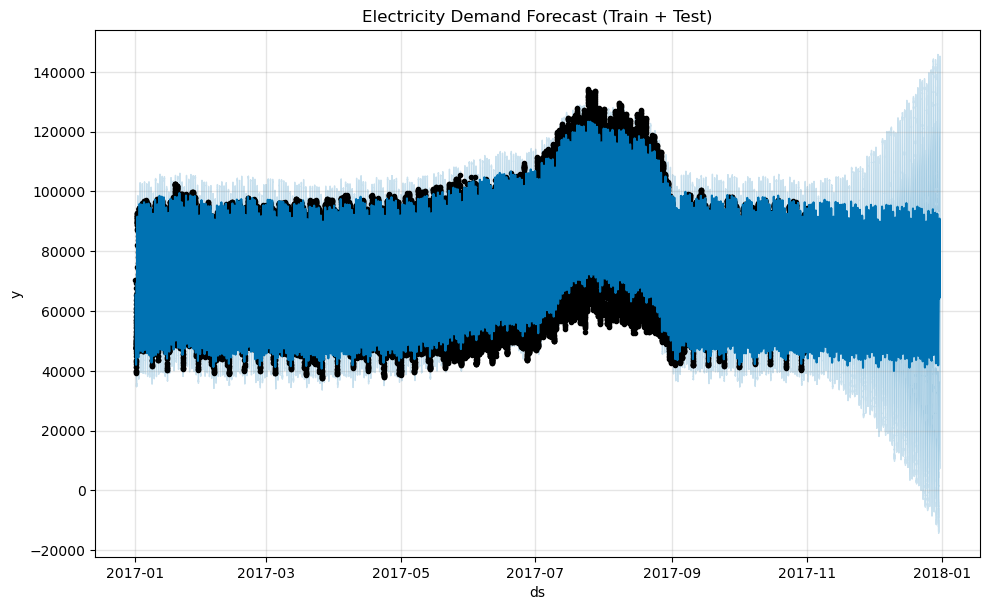

In [68]:
# Step 9: Plots
# Full forecast plot
fig1 = model.plot(forecast)
plt.title("Electricity Demand Forecast (Train + Test)")
plt.show()

#What the graph shows
#X-axis (ds): Dates (2017-01 to 2018-01).
#Y-axis (y): Electricity demand (power consumption).
#Black dots/line: Actual observed demand.
#Blue line + shaded region: Prophet’s forecast (mean prediction + uncertainty interval).
#------------------------------------------------------------------------------------------------
#Light blue shaded area: Confidence interval (uncertainty). Wider at the edges, especially after the training period → typical in forecasting.
#From Jan to Aug 2017, the forecast (blue) follows the actual demand (black) very closely.
#This means the model is capturing seasonality + trends well.

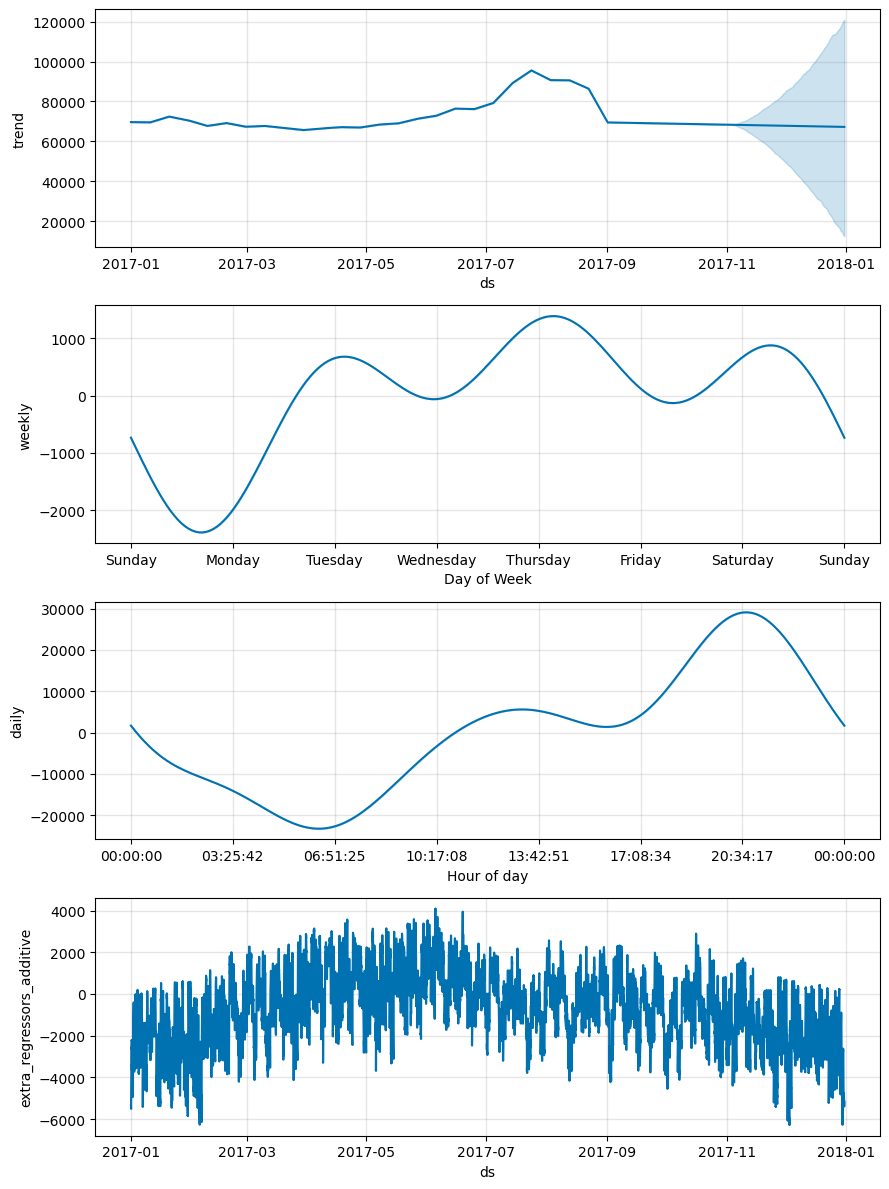

In [69]:
# Components plot
fig2 = model.plot_components(forecast)
plt.show()

# Trend graph show - The blue line is the overall demand trend. 
#The shaded area (uncertainty) grows a lot after Sep, meaning the model is less confident in its long-term forecast.
#This shows Prophet has captured the seasonal peak in summer months.


## Save Prophet model and metadata

In [70]:
# Save Prophet model and metadata from Jupyter
import pickle
import json
import joblib    
import pandas as pd

In [71]:
# Save the new Prophet model
with open("prophet_model_v2.pkl", "wb") as f:
    pickle.dump(model, f)
"✅ Prophet model saved as prophet_model_v2.pkl"

'✅ Prophet model saved as prophet_model_v2.pkl'

In [72]:
# Save the new training dataset
train_prophet.to_csv("training_data_v2.csv", index=False)
f"✅ Training data saved as training_data_v2.csv with shape: {train_prophet.shape}"


'✅ Training data saved as training_data_v2.csv with shape: (43776, 11)'

In [73]:
# Save the new metadata
meta = {
    "regressors": regressors,
    "freq": "10min",
    "ds_name": "ds",
    "y_name": "y",
    "train_start": str(train['ds'].min()),
    "train_end": str(train['ds'].max()),
    "test_start": str(test['ds'].min()),
    "test_end": str(test['ds'].max())
}
with open("model_meta_v2.json", "w") as f:
    json.dump(meta, f, indent=4)
"✅ Metadata saved as model_meta_v2.json"

'✅ Metadata saved as model_meta_v2.json'